<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/img_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movement and deformation analysis from images

##Principles

*   Images/videos are made by a stabil camera (camera not moving during observations)
*   Calibrated camera/system necessary
*   Image resolution is echanced by geodetic telescope


##Methods

*   Template matching
*   Patern recognition

###Template matching characteristics

Pros

*   There is always a match
*   Simple algorithm
*   No special marker neccesary

Contras

*   The chance of false match is higher
*   No or minimal rotation
*   No or minimal scale change

###Pattern recognition charasteristics

Pros

*   Marker can rotate
*   Marker scale can change
*   Normal of the marker can be estimated

Contras


*   Special marker have to fit to target
*   More sensitive for light conditions


Let's import the neccessary Python packages.

In [2]:
import glob
import cv2                          # OpenCV for image processing
from cv2 import aruco               # to find ArUco markers
import numpy as np                  # for matrices
import matplotlib.pyplot as plt     # to show images

##Template matching

Let's first download an image and a template to search for. The template is a smaller part of the original image.

In [1]:
!wget -q -O sample_data/monalisa.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa.jpg
!wget -q -O sample_data/mona_temp4.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/mona_temp4.png

We load the image to process and the template and convert it to grayscale images.

image sizes: (276, 182)  template sizes: (76, 52)


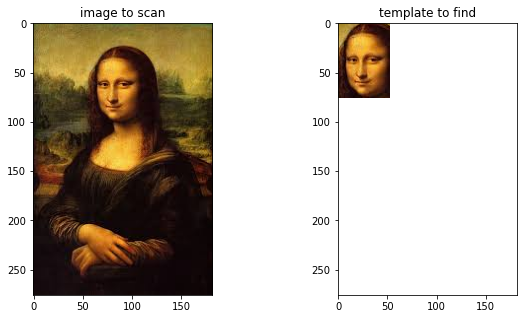

In [3]:
img = cv2.imread('sample_data/monalisa.jpg')          # load image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
templ = cv2.imread('sample_data/mona_temp4.png')      # load template
templ_gray = cv2.cvtColor(templ, cv2.COLOR_BGR2GRAY)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('image to scan')
ax2.imshow(cv2.cvtColor(templ, cv2.COLOR_BGR2RGB))    # BGR vs. RGB
ax2.set_title('template to find')
ax2.set_xlim(ax1.get_xlim())                          # set same scale
ax2.set_ylim(ax1.get_ylim())
print(f'image sizes: {img_gray.shape}  template sizes: {templ_gray.shape}')

OpenCV has a function for template mathing, let's call it and display the result. The *matchTemplate* function can calculate six different formulas to find the best match. *TM_CCOEFF_NORMED* calculates a normalized coefficient in the range (0, 1), the perfect match gives value 1.

best match at (57, 25) value 0.999999


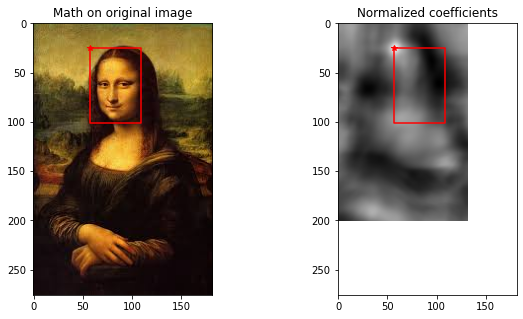

In [4]:
result = cv2.matchTemplate(img_gray, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]        # get position of best match
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]), 
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
result_uint = ((result - np.min(result)) / (np.max(result) - np.min(result)) * 256).astype('uint8')
result_img = cv2.cvtColor(result_uint, cv2.COLOR_GRAY2BGR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Math on original image')
ax1.plot(fr[:,0], fr[:,1], 'r')
ax1.plot([max[0]],[max[1]], 'r*')
ax2.imshow(result_img)
ax2.plot(fr[:,0], fr[:,1], 'r')
ax2.plot([max[0]],[max[1]], 'r*')
ax2.set_title('Normalized coefficients')
ax2.set_xlim(ax1.get_xlim())                          # set same scale
ax2.set_ylim(ax1.get_ylim())
print(f'best match at {max} value {val:.6f}')


###Image transformation

If the pattern is rotated or scaled, the pattern might not match the image. We can fix this issue by using homology matrix. For more details see: [source](https://github.com/jephraim-manansala/object-detection/blob/master/Object%20Detection%20using%20Template%20Matching.ipynb)

Let's download another image with a rotated Mona Lisa.

In [5]:
!wget -q -O sample_data/monalisa_tilt.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa_tilt.jpg

Let's try to find the template on the rotated image.

best match at (467, 240) value 0.574015 BUT FALSE!


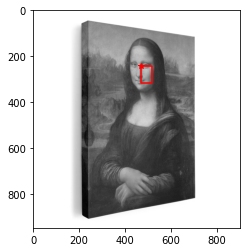

In [6]:
img = cv2.imread('sample_data/monalisa_tilt.jpg', cv2.IMREAD_GRAYSCALE)
result = cv2.matchTemplate(img, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]), 
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
plt.imshow(img, cmap="gray")
plt.plot(fr[:,0], fr[:,1], 'r')
plt.plot([max[0]],[max[1]], 'r*')
print(f'best match at {max} value {val:.6f} BUT FALSE!')

Let's transform back the image to perpendicular plain.

In [7]:
def project_img(image, a_src, a_dst):
    """ calculate transformation matrix """
        
    new_image = image.copy()                       # make a copy of input image
    # get parameters of transformation
    projective_matrix = cv2.getPerspectiveTransform(a_src, a_dst)
    # transform image
    transformed = cv2.warpPerspective(img, projective_matrix, image.shape)
    # cut destination area
    transformed = transformed[0:int(np.max(a_dst[:,1])),0:int(np.max(a_dst[:,0]))]
    return transformed

best match at (55, 19) value 0.92


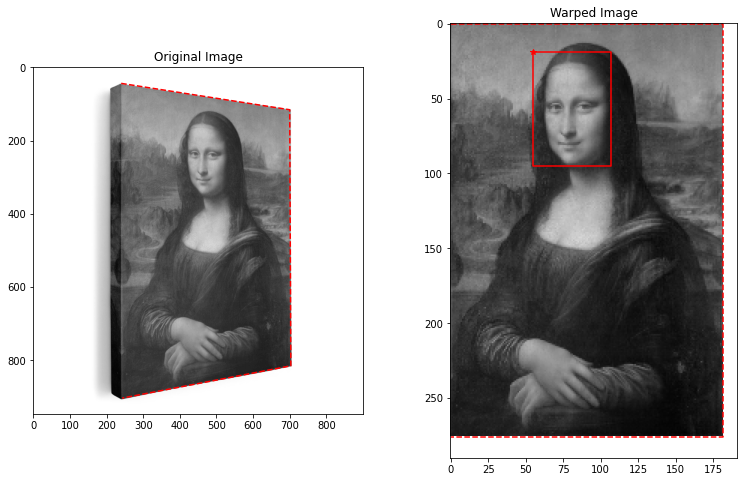

In [8]:
# frame on warped image
src = [(240, 44), (700, 116), (703, 815), (243, 903)]
# frame on original
s = img_gray.shape
dst = [(0, 0), (s[1], 0), (s[1], s[0]), (0,s[0])]
a_src = np.float32(src)
a_dst = np.float32(dst)
# image transformation
img_dst = project_img(img, a_src, a_dst)
# template match
result = cv2.matchTemplate(img_dst, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
# frame around template on transformed image
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]), 
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
fig, ax = plt.subplots(1,2, figsize=(13,8)) 
ax[0].imshow(img, cmap="gray");
ax[0].plot(a_src[:,0], a_src[:,1], 'r--')
ax[0].set_title('Original Image')
ax[1].imshow(img_dst, cmap="gray")
ax[1].plot(a_dst[:,0], a_dst[:,1], 'r--')
ax[1].set_title('Warped Image')
ax[1].plot(fr[:,0], fr[:,1], 'r')
ax[1].plot([max[0]],[max[1]], 'r*')
print(f'best match at {max} value {val:.2f}')

##Recognition of ArUco markers

"An ArUco marker is a synthetic square marker composed by a wide black border and an inner binary matrix which determines its identifier (id). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. The marker size determines the size of the internal matrix. For instance a marker size of 4x4 is composed by 16 bits." (*from OpenCV documentation*)

There is a contrib package in OpenCV to detect ArUco markers called *aruco*.

Let's try first to find six ArUco markers on a simple image-

In [20]:
!wget -q -O sample_data/markers.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/markers.png
img = cv2.imread('sample_data/markers.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

[(502.0, 342.0), (328.0, 342.0), (152.0, 342.0), (502.0, 142.0), (328.0, 142.0), (152.0, 142.0)]


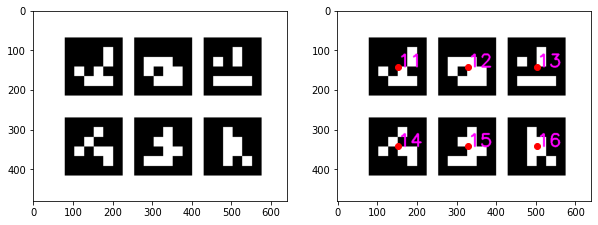

In [31]:
aruco_dict = aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
params = aruco.DetectorParameters_create()
corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
x = np.zeros(ids.size)
y = np.zeros(ids.size)
img1 = img.copy()
for j in range(ids.size):
  x[j] = int(round(np.average(corners[j][0][:, 0])))
  y[j] = int(round(np.average(corners[j][0][:, 1])))
  cv2.putText(img1, str(ids[j][0]), (int(x[j]+2), int(y[j])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 255), 3)
fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(img)
ax[1].imshow(img1)
ax[1].plot(x, y, "ro")
print(list(zip(list(x), list(y))))

##Calibration

Low-cost cameras have significant distortions (radial and tangential). We have to calibrate cameras before using in deformation and movement analysis.

###Radial distortion

$$ x' = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$
$$ y' = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$

###Tangential distortion

$$ x' = x + (2 p_1 x y + p_2 (r^2 + 2 x^2)) $$
$$ y' = y + (p_1 (r^2+2 y^2) + 2 p_2 x y) $$

###Camera matrix

<table>
<tr><td>f<sub>x</sub></td><td>0</td><td>c<sub>x</sub></td></tr>
<tr><td>0</td><td>f<sub>y</sub></td><td>c<sub>y</sub></td></tr>
<tr><td>0</td><td>0</td><td>1</td></tr>

For the calibration we need a chessboard like figure and more than ten photos from different directions.

Let's download first the images for calibration.

In [36]:
!wget -q -O sample_data/cal.zip https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/cal.zip
!unzip -q -o sample_data/cal.zip -d sample_data

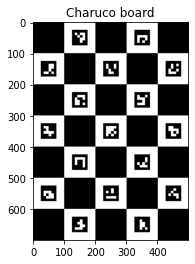

In [42]:

width = 5       # Charuco board size
height = 7
board = cv2.aruco.CharucoBoard_create(width, height, .025, .0125, aruco_dict)   # generate board in memory
img = board.draw((500, 700))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
_ = plt.title('Charuco board')

Using the ArUco calibration let's find the camera matrix and radial and tangential distortion.

In [43]:
allCorners = []
allIds = []
decimator = 0

for name in glob.glob("sample_data/cal*.jpg"):
  frame = cv2.imread(name)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict)
  ret, corners1, ids1 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
  allCorners.append(corners1)
  allIds.append(ids1)
  decimator += 1

ret, mtx, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(allCorners, allIds, board, gray.shape, None, None)
print("Camera matrix [pixels]")
for i in range(mtx.shape[0]):
  print(f'{mtx[i][0]:8.1f} {mtx[i][1]:8.1f} {mtx[i][2]:8.1f}')
print('Radial components')
print(30 * '-')
print(f'{dist[0][0]:10.5f} {dist[0][1]:10.5f} {dist[0][2]:10.5f}')
print(30 * '-')
print('Tangential components')
print(f'{dist[0][3]:10.5f} {dist[0][4]:10.5f}')

Camera matrix [pixels]
 28024.8      0.0   1379.3
     0.0  26853.3   1486.8
     0.0      0.0      1.0
Radial components
------------------------------
  74.78224  -31.09830    0.67543
------------------------------
Tangential components
  -0.58000   -0.10764


Undistored image, corrected by calibration parameters

Text(0.5, 1.0, 'undistorted image')

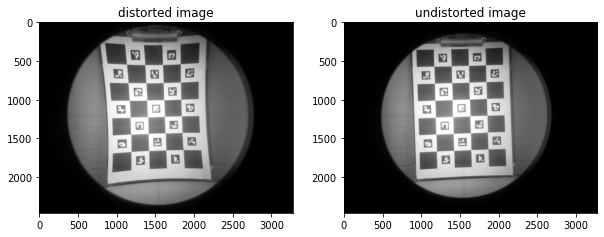

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10,5)) 
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('distorted image')
ax[1].imshow(cv2.undistort(gray, mtx, dist, None), cmap='gray')
ax[1].set_title('undistorted image')

##Complex example

We have a video of a moving object with an ArUco marker. Let's process the video frame by frame and make a plot. During the process images are corrected by the calibration data.

[Click here](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4) to watch video.


In [45]:
!wget -q -O sample_data/demo.mp4 https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4

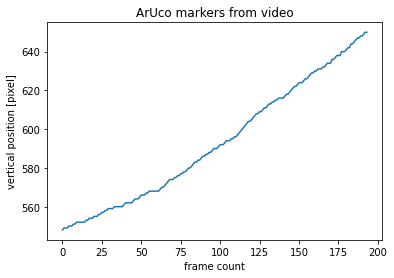

In [50]:
cap = cv2.VideoCapture('sample_data/demo.mp4')
frame = 0                 # frame counter
xc = []                   # for pixel coordinates of marker
yc = []
frames = []
while True:
  ret, img = cap.read()   # get next frame from video
  if ret:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.undistort(gray, mtx, dist, None)
    corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
    if ids:
      yc.append(img_gray.shape[1] - int(round(np.average(corners[0][0][:, 1]))))  # change y direction
      frames.append(frame)
    frame += 1
  else:
    break       # no more images
plt.plot(frames, yc)
plt.title('ArUco markers from video')
plt.xlabel('frame count')
_ = plt.ylabel('vertical position [pixel]')

##Tasks


*   Try to use both methods with your own images
*   Blur the images (monalisa.jpg, markers.png) and try to use both methods
* Modify the code of the complex example to use template matching method
* In the complex example try to change pixels to mm and frames to seconds (video has 2 fps, the size of the marker is 6.5 cm).
* Calibrate the camera of your mobile
